In [157]:
import geopandas as gpd
import pandas as pd
import numpy  as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing
from sklearn import cross_validation 
from sklearn import ensemble
from sklearn import metrics
from sklearn import tree
import pylab as plt
pl.rcParams["font.size"] = 18
pl.rcParams["figure.figsize"] = (10,10)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## reading in data

I used [this code](https://github.com/ChrisMuir/Zillow) but Chris Muir to download Zillow details for properties in zipcodes starting with 10 and 11 (it was a lot of fun, it uses Selene to open a chrome window and runs it under your eyes. You can interact with it, so you can show you are not a robot, although the code running the window is. Notice that scraping Zillow is against Zillow's policy

read in zillow data

In [158]:
nychouses = pd.read_csv("allzips.csv")

In [159]:
nychouses.head()

,address,city,state,zip,price,sqft,bedrooms,bathrooms,days_on_zillow,sale_type,url
0,263 9th Ave APT 6B,New York,NY,10001,2599988,1536.0,2.0,2.0,NaN,Condo For Sale,http://www.zillow.com/homes/for_sale//homedeta...
1,15 Hudson Yards # 67E,New York,NY,10001,7575000,2497.0,2.0,3.0,NaN,Condo For Sale,http://www.zillow.com/homes/for_sale//homedeta...
2,15 Hudson Yards # PH86D,New York,NY,10001,8475000,2515.0,3.0,4.0,NaN,Condo For Sale,http://www.zillow.com/homes/for_sale//homedeta...
3,540 W 28th St PH A,New York,NY,10001,3550000,1755.0,2.0,2.0,NaN,Condo For Sale,http://www.zillow.com/homes/for_sale//homedeta...
4,15 Hudson Yards # 34G,New York,NY,10001,4420000,1460.0,2.0,3.0,NaN,Condo For Sale,http://www.zillow.com/homes/for_sale//homedeta...


read in zipcode shapefile to select only NYC zipcodes from Zillow file

In [160]:
zips = gpd.read_file("../../science/Dropbox/UI/PUIdata/" +
    #os.getenv("PUIDATA") + 
                     "/ZIP_CODE_040114.shp")
zips.head()

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,2.369863e+07,0,Kings,047,56527.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,3.686880e+07,0,Kings,047,72280.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


## data preprocessing

### merge zillow w NYC zips shapefile to get only NYC listings

In [161]:
nychouses = nychouses.merge(zips[["ZIPCODE"]], left_on="zip", right_on="ZIPCODE")

### clean up data

In [162]:
nychouses.drop(["ZIPCODE", 'city', 'state', 'url', 'address'], axis=1, inplace=True)

In [163]:
nychouses.columns


Index([u'zip', u'price', u'sqft', u'bedrooms', u'bathrooms', u'days_on_zillow',
       u'sale_type'],
      dtype='object')

In [164]:
#days on zillow would be interesting, but it came up as nan
nychouses.drop(["days_on_zillow"], axis=1, inplace=True)

In [165]:
# removing nans cause sklearn random forest cant deal with them
nychouses.dropna(inplace=True)

In [166]:
for f in [u'price',           u'sqft',
             u'bedrooms',      u'bathrooms']:  
    nychouses[f] = nychouses[f].map(float)

In [167]:
nychouses.head()

,zip,price,sqft,bedrooms,bathrooms,sale_type
0,10001,2599988.0,1536.0,2.0,2.0,Condo For Sale
1,10001,7575000.0,2497.0,2.0,3.0,Condo For Sale
2,10001,8475000.0,2515.0,3.0,4.0,Condo For Sale
3,10001,3550000.0,1755.0,2.0,2.0,Condo For Sale
4,10001,4420000.0,1460.0,2.0,3.0,Condo For Sale


### creating a categorical target variable from the price  to demonstrate classification trees:
is price >1M -> 1

else -> 0

In [168]:
yc = np.array([1 if c > 1e6 else 0 for c in nychouses.price])
yc

array([1, 1, 1, ..., 1, 0, 0])

### Option 1 to deal with categorical data

In [169]:
nychouses.sale_type.unique()

array(['Condo For Sale', 'Townhouse For Sale', 'For Sale by Owner',
       'Co-op For Sale', 'Apartment For Sale', 'House For Sale',
       'New Construction', 'Foreclosure', 'Foreclosed', 'Auction'], dtype=object)

technically each feature should be a binary - one-hot encoding this feature would generate 10 binary features (is it a Condo For Sale y/2, is it a Foreclosure Y/N) but of there are few choices it is also ok to encode them as numerical features.

In [170]:
nychouses["sale_type_num"] = pd.Categorical.from_array(nychouses.sale_type).codes

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
  if __name__ == '__main__':


In [171]:
nychouses.head()

,zip,price,sqft,bedrooms,bathrooms,sale_type,sale_type_num
0,10001,2599988.0,1536.0,2.0,2.0,Condo For Sale,3
1,10001,7575000.0,2497.0,2.0,3.0,Condo For Sale,3
2,10001,8475000.0,2515.0,3.0,4.0,Condo For Sale,3
3,10001,3550000.0,1755.0,2.0,2.0,Condo For Sale,3
4,10001,4420000.0,1460.0,2.0,3.0,Condo For Sale,3


#### whitening

In [172]:
Xnum = preprocessing.scale(nychouses.drop(["price","sale_type"], axis=1))
yy = preprocessing.scale(nychouses.price)

### Option 2 to deal w categorical data: one-hot encoding
1hot encoding all categorical data: sale_type and zipcode as well

In [173]:
nyc1hot = pd.merge(nychouses, pd.get_dummies(nychouses[u'zip']), 
         left_index=True, right_index=True).merge(pd.get_dummies(nychouses["sale_type"]), 
                                                  left_index=True, 
                                                  right_index=True).drop(["zip", "sale_type", 
                                                                          "sale_type_num"], 
                                                                    axis=1)
nyc1hot.head()

,price,sqft,bedrooms,bathrooms,10001,10002,10004,10006,10007,10010,...,Apartment For Sale,Auction,Co-op For Sale,Condo For Sale,For Sale by Owner,Foreclosed,Foreclosure,House For Sale,New Construction,Townhouse For Sale
0,2599988.0,1536.0,2.0,2.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,7575000.0,2497.0,2.0,3.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,8475000.0,2515.0,3.0,4.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,3550000.0,1755.0,2.0,2.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4420000.0,1460.0,2.0,3.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [174]:
nyc1hot.columns

Index([u'price', u'sqft', u'bedrooms', u'bathrooms', u'10001', u'10002',
       u'10004', u'10006', u'10007', u'10010', u'10011', u'10012', u'10013',
       u'10014', u'10016', u'10017', u'10018', u'10019', u'10021', u'10022',
       u'10023', u'10024', u'10025', u'10026', u'10027', u'10028', u'10029',
       u'10030', u'10031', u'10032', u'10033', u'10034', u'10035', u'10036',
       u'10037', u'10038', u'10039', u'10040', u'10044', u'10065', u'10069',
       u'10075', u'10128', u'11001', u'11004', u'11005', u'11040', u'11096',
       u'11101', u'11102', u'11103', u'11104', u'11105', u'11106', u'11109',
       u'11201', u'11229', u'11235', u'11355', u'11361', u'11364', u'11365',
       u'11436', u'Apartment For Sale', u'Auction', u'Co-op For Sale',
       u'Condo For Sale', u'For Sale by Owner', u'Foreclosed', u'Foreclosure',
       u'House For Sale', u'New Construction', u'Townhouse For Sale'],
      dtype='object')

#### whitening

In [175]:
X1hot = preprocessing.scale(nyc1hot.drop("price", axis=1))

In [176]:
y = preprocessing.scale(nyc1hot.price)
y

array([-0.1529786 ,  0.2247512 ,  0.29308406, ...,  1.61988051,
       -0.28668233, -0.31629324])

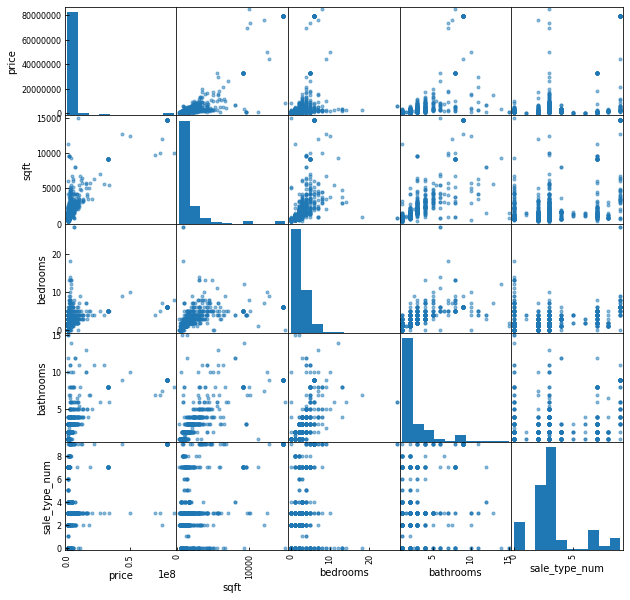

In [257]:
#takse too long
pd.scatter_matrix(nychouses, figsize=(10,10));

# Single Tree Classifier

categorical 1-hot encoded 

In [258]:
X1hot.shape

(1100, 72)

In [259]:
tree.DecisionTreeClassifier?

In [260]:
onetree_1hotencoded =  tree.DecisionTreeClassifier(random_state=112).fit(X1hot, yc)
print ("in-sample score of tree classifier %.6f"%onetree_1hotencoded.score(X1hot, yc))

in-sample score of tree classifier 0.998182


categorical encoded as numerical

In [261]:
Xnum.shape

(1100, 5)

In [262]:
onetree_numencoded =  tree.DecisionTreeClassifier(random_state=112).fit(Xnum, yc)
print ("in-sample score of 1-hot encoded tree classifier %.6f"%onetree_numencoded.score(Xnum, yc))

in-sample score of 1-hot encoded tree classifier 0.998182


 plot trees

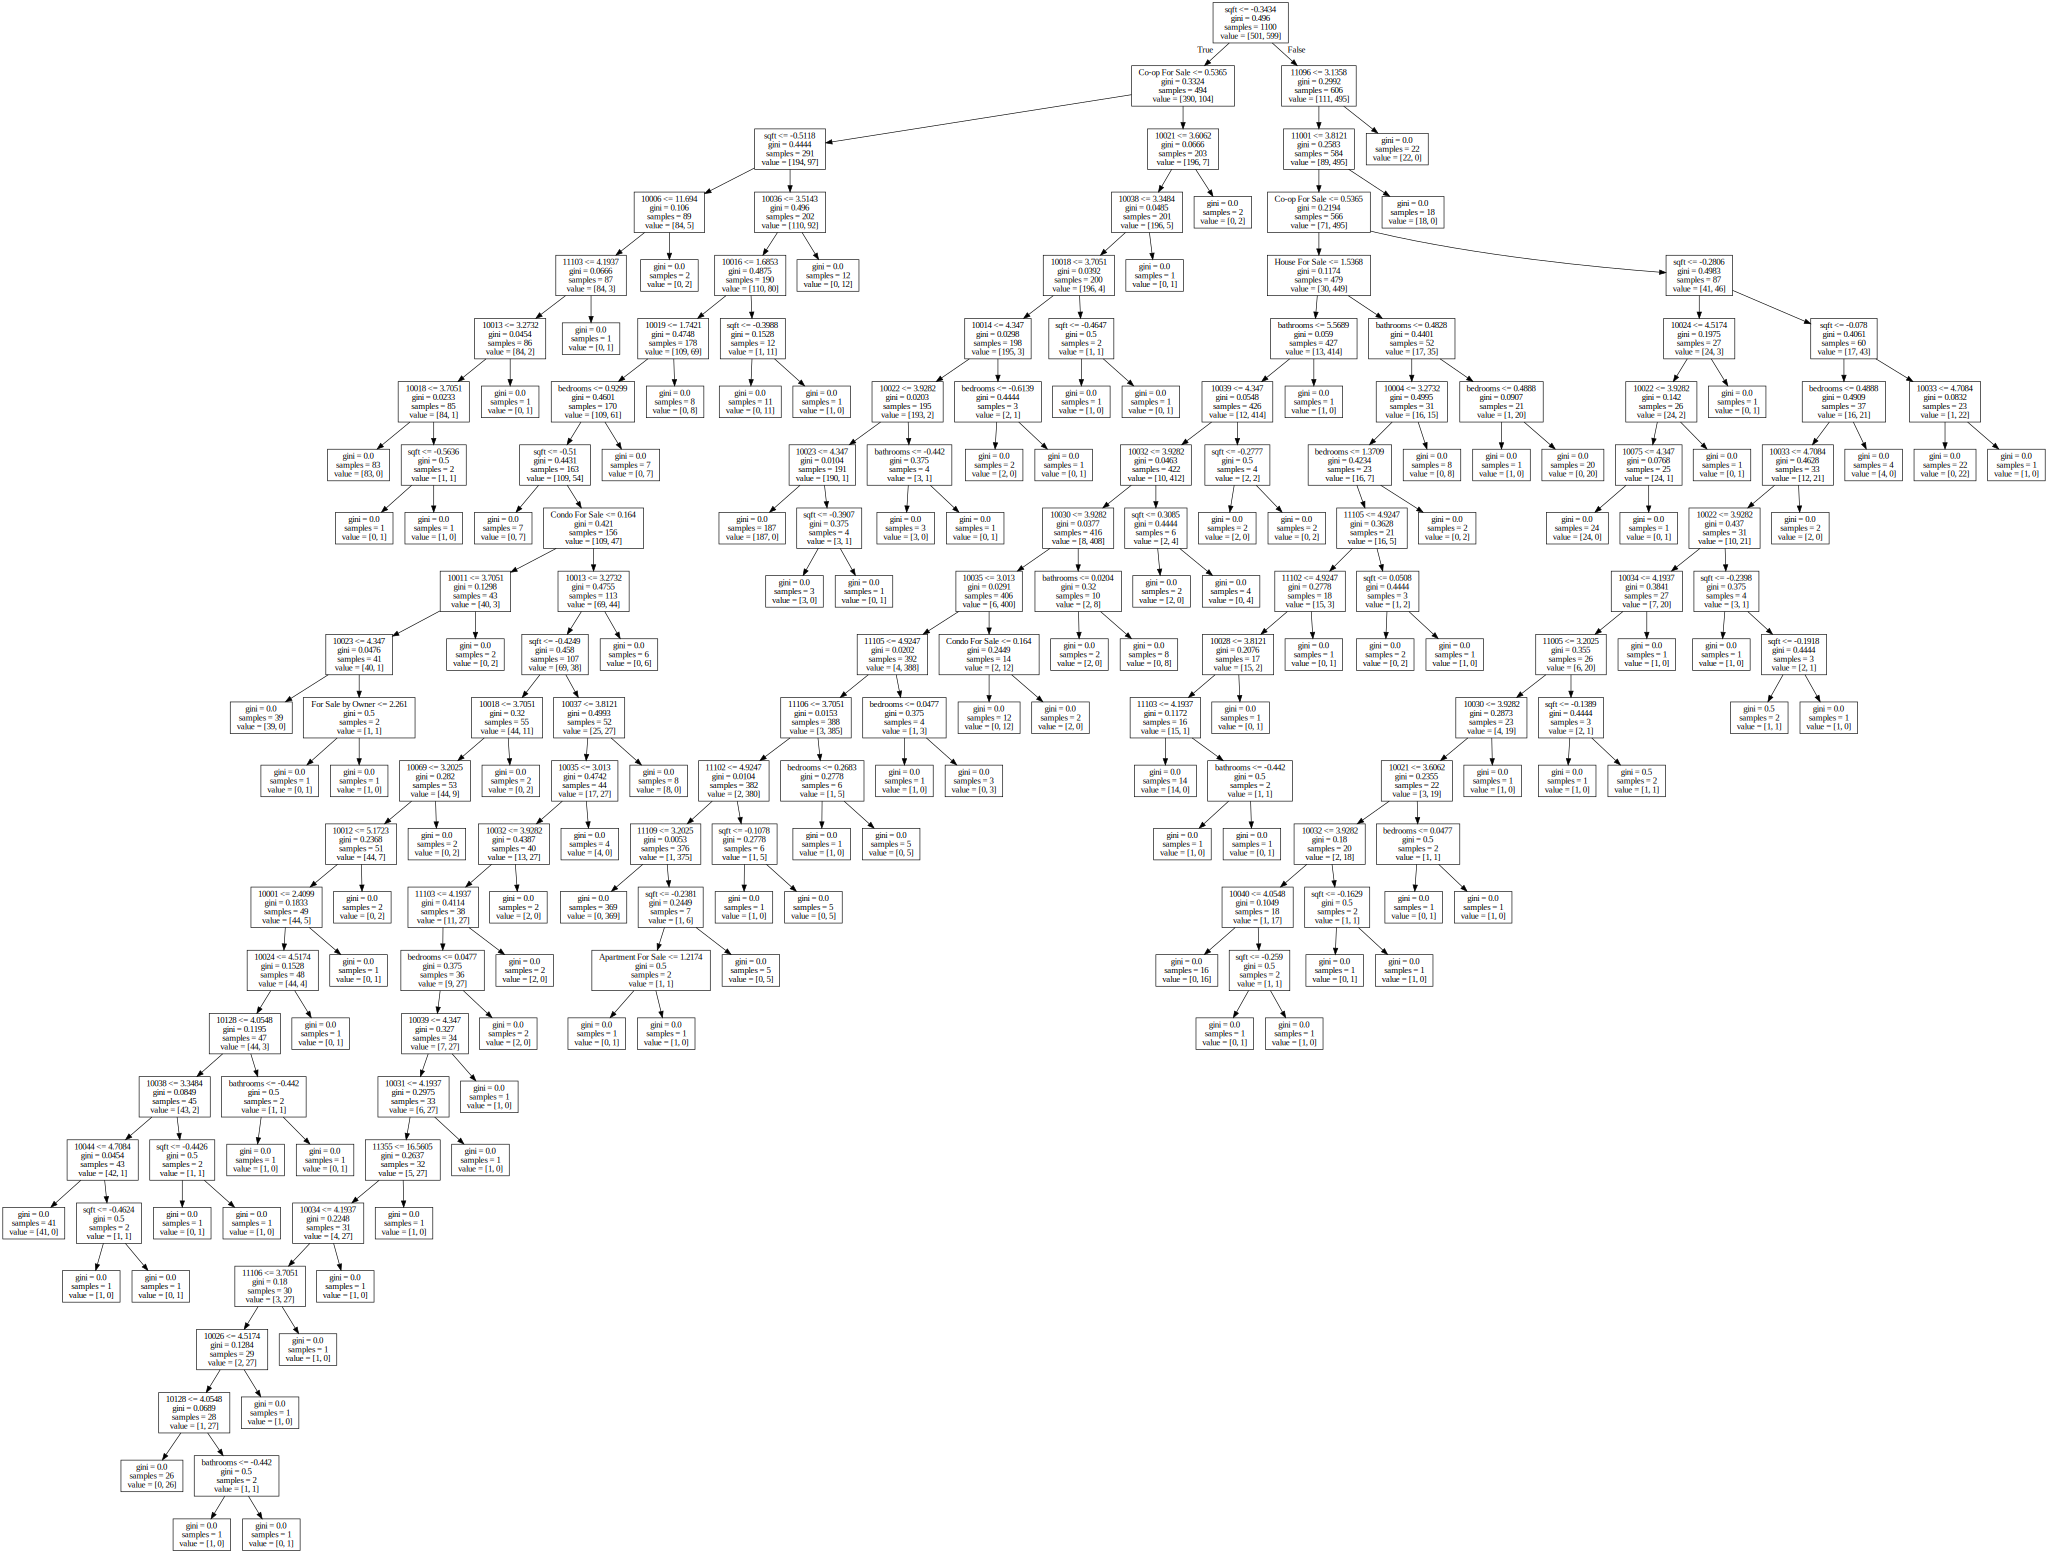

In [263]:
import graphviz 
dot_data = tree.export_graphviz(onetree_1hotencoded, 
                                feature_names=nyc1hot.drop("price", axis=1).columns, 
                                out_file=None) 
graph = graphviz.Source(dot_data)
graph

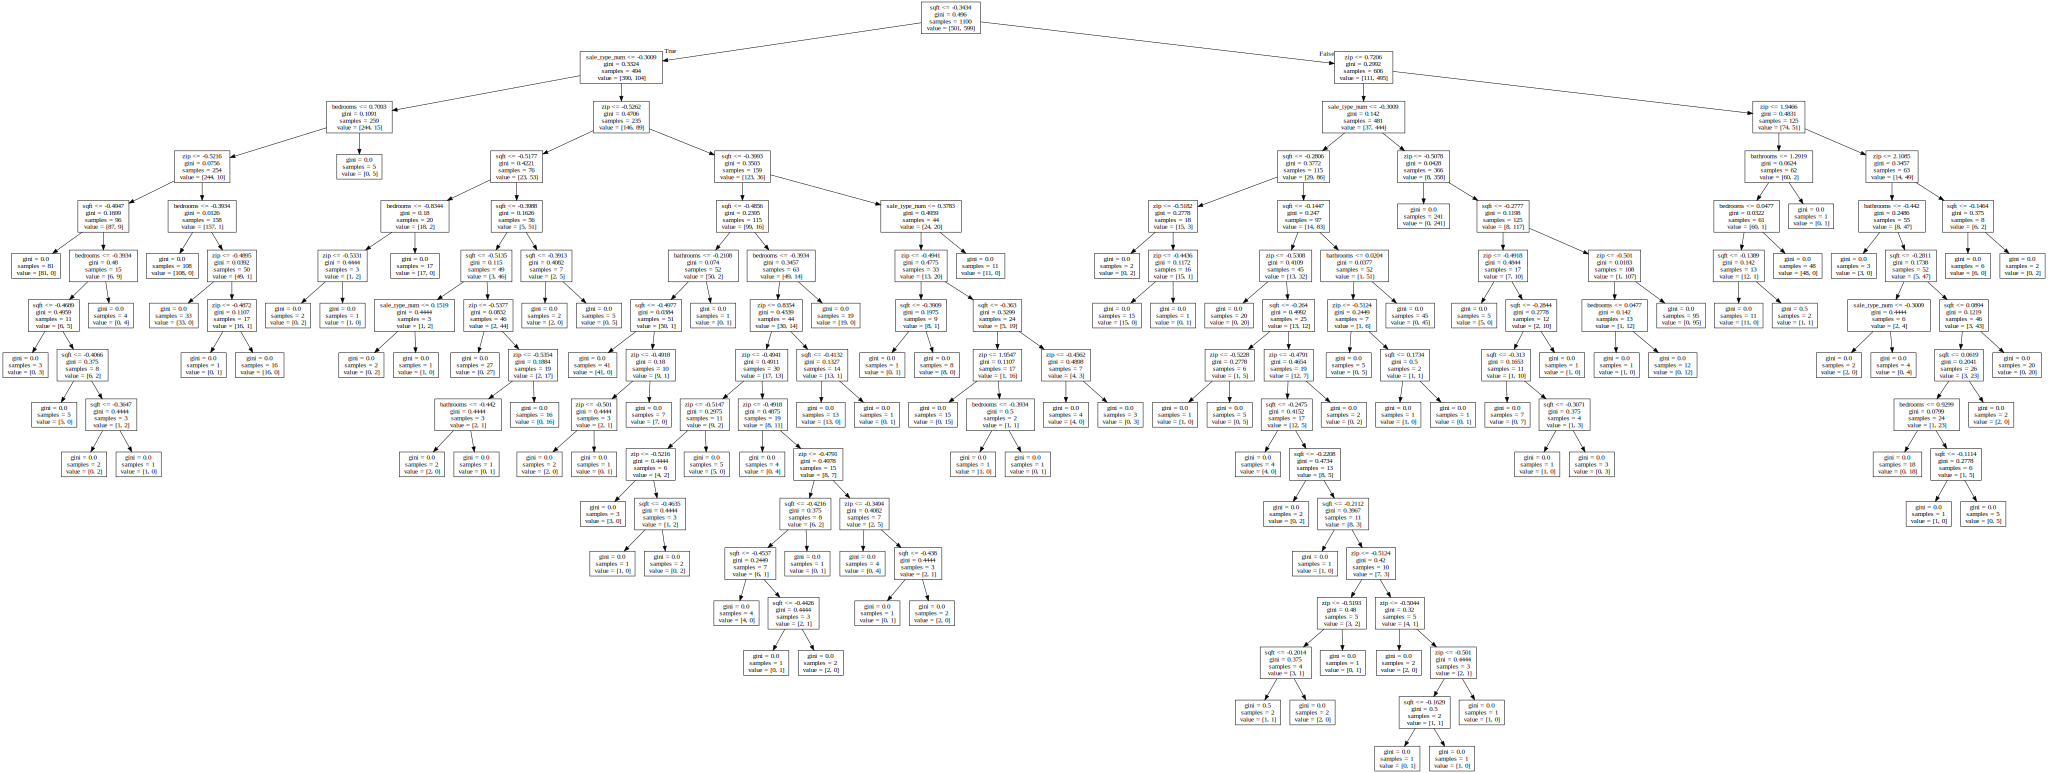

In [264]:
dot_data = tree.export_graphviz(onetree_numencoded, 
                                feature_names=nychouses.drop(["price","sale_type"], axis=1).columns, 
                                out_file=None) 
graph = graphviz.Source(dot_data) 
graph

# comparison with regression models - in sample comparison

## Regression

### Linear regression

In [265]:
linearReg = linear_model.LinearRegression()
linearReg = linearReg.fit(Xnum, y)
print ("in-sample score of linear regression %.2f"%linearReg.score(Xnum, y))

in-sample score of linear regression 0.81


### Ridge regression: regression with penalization for high coefficients

In [266]:
ridge = linear_model.RidgeCV()
ridge = ridge.fit(Xnum, y)
print ("in-sample score of ridge regression %.2f"%ridge.score(Xnum, y))

in-sample score of ridge regression 0.81


## Categorical

### Ridge classification (Categorical version of Ridge regression)

In [267]:
ridgec = linear_model.RidgeClassifierCV()
ridgec = ridgec.fit(X1hot, yc)
print ("in-sample score of ridge classification %.2f"%ridgec.score(X1hot, yc))

in-sample score of ridge classification 0.91


### Logistic regression (NB: its always categorical)

In [268]:
logisticc = linear_model.LogisticRegressionCV()
logisticc = logisticc.fit(X1hot, yc)
print ("in-sample score of logistic regression (classification) %.2f"%logisticc.score(X1hot, yc))

in-sample score of logistic regression (classification) 0.95


## CART: Classification and Regression Tree Methods

## Tree Classification models

### Random Forest

In [269]:
rfc = ensemble.RandomForestClassifier()
rfcat = rfc.fit(X1hot, yc)
print ("in-sample score of random forest classifier (one-hot) %.2f"%rfcat.score(X1hot,yc))

in-sample score of random forest classifier (one-hot) 0.99


In [270]:
rfn = ensemble.RandomForestClassifier()
rfnum = rfn.fit(Xnum, yc)
print ("in-sample score of random forest classifier (numerical) %.2f"%rfnum.score(Xnum,yc))

in-sample score of random forest classifier (numerical) 0.99


### Gradient boosted trees

In [271]:
gbc = ensemble.GradientBoostingClassifier()
gbcat = gbc.fit(X1hot, yc)
print ("in-sample score of gradient boosted tree classifier (one-hot) %.2f"%gbcat.score(X1hot,yc))

in-sample score of gradient boosted tree classifier (one-hot) 0.96


In [272]:
gbn = ensemble.GradientBoostingClassifier()
gbnum = gbn.fit(Xnum, yc)
print ("in-sample score of gradient boosted tree classifier (one-hot) %.2f"%gbnum.score(Xnum,yc))

in-sample score of gradient boosted tree classifier (one-hot) 0.97


## Tree regression models

### Random Forest

In [273]:
rfr = ensemble.RandomForestRegressor()
rfreg1hot = rfr.fit(X1hot, y)
print ("in-sample score of random forest regression %.2f"%rfreg1hot.score(X1hot,y))

in-sample score of random forest regression 1.00


In [274]:
rfreg = rfr.fit(Xnum, y)
print ("in-sample score of random forest regression %.2f"%rfreg.score(Xnum,y))

in-sample score of random forest regression 0.99


### Gradient boosted trees

In [275]:
gbr = ensemble.GradientBoostingRegressor()
gbreg1hot = gbr.fit(X1hot, y)
print ("in-sample score of gradient boosted regression %.2f"%gbreg1hot.score(X1hot,y))

in-sample score of gradient boosted regression 1.00


In [276]:
gbreg = gbr.fit(Xnum, y)
print ("in-sample score of gradient boosted regression %.2f"%gbreg.score(Xnum,y))

in-sample score of gradient boosted regression 1.00


### NOTE: these models are certainly overfitting and need to be pruned!

# out of sample comparisons

### split sampoe into training and testting set (60-30 split)

In [277]:
#regression sample
X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xnum, y, test_size=0.3, random_state=0)

# classification sample
Xc_train, Xc_test, yc_train, yc_test = cross_validation.train_test_split(Xnum, yc, test_size=0.3, random_state=0)

# classsification sample one-hot encoded
X1hot_train, X1hot_test, y1hot_train, y1hot_test = cross_validation.train_test_split(X1hot, yc, test_size=0.3, random_state=0)


## Categorical

### logistic

In [278]:
logisticc = linear_model.LogisticRegressionCV().fit(X1hot_train, y1hot_train)
print ("score of logistic regression in-sample %.2f, out-sample %.2f"%(
        logisticc.score(X1hot_train, y1hot_train), logisticc.score(X1hot_test, y1hot_test)))

score of logistic regression in-sample 0.95, out-sample 0.91


### ridge 

In [279]:
ridgec = ridgec.fit(X1hot_train, y1hot_train)
print ("sample score of ridge classifier (one-hot) in-sample %.2f, out-sample %.2f"%(
        ridgec.score(X1hot_train, y1hot_train), ridgec.score(X1hot_test, y1hot_test)))

sample score of ridge classifier (one-hot) in-sample 0.93, out-sample 0.90


In [280]:
ridgec = ridgec.fit(Xc_train, yc_train)
print ("sample score of ridge classifier numerical encoding in-sample %.2f, out-sample %.2f"%(
        ridgec.score(Xc_train, yc_train), ridgec.score(Xc_test, yc_test)))

sample score of ridge classifier numerical encoding in-sample 0.82, out-sample 0.80


### single tree

In [281]:
onetree =  tree.DecisionTreeClassifier().fit(X1hot_train, y1hot_train)
print ("out of sample score of single tree (one-hot) in-sample %.2f, out-sample %.2f"%(
        onetree.score(X1hot_train, y1hot_train), onetree.score(X1hot_test, y1hot_test)))

out of sample score of single tree (one-hot) in-sample 1.00, out-sample 0.90


### random forest

In [282]:
rfcat = rfc.fit(X1hot_train, y1hot_train)
print ("out of sample score of random forest (one-hot) %.2f"%rfcat.score(X1hot_test, y1hot_test))

out of sample score of random forest (one-hot) 0.91


### gradient boosted

In [283]:
gbcat = gbc.fit(X1hot_train, y1hot_train)
print ("out of sample score of gradient boosted (one-hot) %.2f"%gbcat.score(X1hot_test, y1hot_test))

out of sample score of gradient boosted (one-hot) 0.91


## Regression

### linear

In [284]:
linear = linear_model.LinearRegression().fit(X_train, y_train)
print ("regression score of linear regression in-sample %.2f, out-sample %.2f"%(
        linear.score(X_train, y_train), linear.score(X_test, y_test)))

regression score of linear regression in-sample 0.81, out-sample 0.81


### ridge

In [285]:
ridge = ridge.fit(X_train, y_train)
print ("out of sample score of ridge regression in-sample %.2f, out-sample %.2f"%(
        ridge.score(X_train, y_train), ridge.score(X_test, y_test)))

out of sample score of ridge regression in-sample 0.81, out-sample 0.81


### one tree

In [286]:
onetree =  tree.DecisionTreeRegressor().fit(X_train, y_train)
print ("regression: score of single tree numerical encoding  in-sample %.2f, out-sample %.2f"%(
        onetree.score(X_train, y_train), onetree.score(X_test, y_test)))

regression: score of single tree numerical encoding  in-sample 1.00, out-sample 0.85


In [287]:
onetree =  tree.DecisionTreeClassifier().fit(X_train, yc_train)
print ("classification: sample score of single tree numerical encoding  in-sample %.2f, out-sample %.2f"%(
        onetree.score(X_train, yc_train), onetree.score(X_test, yc_test)))

classification: sample score of single tree numerical encoding  in-sample 1.00, out-sample 0.91


In [288]:
onetree =  tree.DecisionTreeClassifier().fit(X1hot_train, y1hot_train)
print ("classification: score of single tree one-hot encoding  in-sample %.2f, out-sample %.2f"%(
        onetree.score(X1hot_train, y1hot_train), onetree.score(X1hot_test, y1hot_test)))

classification: score of single tree one-hot encoding  in-sample 1.00, out-sample 0.90


### random forest

In [289]:
rf = rfr.fit(X_train, y_train)
print ("regression: out of sample score of random forest numerical encoding in-sample %.2f, out-sample %.2f"%(
        rf.score(X_train, y_train), rf.score(X_test, y_test)))

regression: out of sample score of random forest numerical encoding in-sample 0.98, out-sample 0.90


In [290]:
rfnum = rfn.fit(X_train, yc_train)
print ("out of sample score of random forest numerical encoding in-sample %.2f, out-sample %.2f"%(
        rfnum.score(X_train, yc_train), rfnum.score(X_test, yc_test)))

out of sample score of random forest numerical encoding in-sample 1.00, out-sample 0.91


In [291]:
rfcat = rfc.fit(X1hot_train, y1hot_train)
print ("out of sample score of random forest one-hot in-sample %.2f, out-sample %.2f"%(
        rfcat.score(X1hot_train, y1hot_train), rfcat.score(X1hot_test, y1hot_test)))

out of sample score of random forest one-hot in-sample 0.99, out-sample 0.93


### gradient boosted trees

In [292]:
gb = gbr.fit(X_train, y_train)
print ("regression: out of sample score of gradient boosted numerical encoding in-sample %.2f, out-sample %.2f"%(
        gb.score(X_train, y_train), gb.score(X_test, y_test)))

regression: out of sample score of gradient boosted numerical encoding in-sample 1.00, out-sample 0.92


In [293]:
gbnum = gbn.fit(X_train, yc_train)
print ("classification: out of sample score of gradient boosted numerical encoding in-sample %.2f, out-sample %.2f"%(
        gbnum.score(X_train, yc_train), gbnum.score(X_test, yc_test)))

classification: out of sample score of gradient boosted numerical encoding in-sample 0.98, out-sample 0.92


In [294]:
gbcat = gbc.fit(X1hot_train, y1hot_train)
print ("classification: out of sample score of gradient boosted one-hot in-sample %.2f, out-sample %.2f"%(
        gbcat.score(X1hot_train, y1hot_train), gbcat.score(X1hot_test, y1hot_test)))

classification: out of sample score of gradient boosted one-hot in-sample 0.96, out-sample 0.91


 | |    ||      |      regression|        ||       |CART |           |
|---|----||----|-----|----------|---------||---------|----------|---------|
|**purpose**| **encoding** || linear reg | logistic | ridge|| one tree | RF |GBT |
|regression|numerical||0.81/0.81||0.81/0.81||1.00/0.91|0.99/0.94|1.0/0.93|
|classification|numerical||||0.82/0.80||1.00/0.91|1.00/0.91|0.88/079|
|classification|one-hot|||0.93/0.91|0.95/0.91||0.99/0.91|0.99/0.91|0.96/0.91|




## ROC curves provide a better metric for comparison: 
plot false positive rate vs false negative rate (completeness vs accuracy)

In [295]:
# evaluate the model using 10-fold cross-validation
print ("one-hot encoding")

scores = cross_validation.cross_val_score(ensemble.RandomForestClassifier(), 
                         X1hot, yc, scoring='roc_auc', cv=10)
print("Ridge {:.2f}".format(scores.mean()))

scores = cross_validation.cross_val_score(ensemble.RandomForestClassifier(), 
                         X1hot, yc, scoring='roc_auc', cv=10)
print("RF {:.2f}".format(scores.mean()))

scores = cross_validation.cross_val_score(ensemble.RandomForestClassifier(), 
                         X1hot, yc, scoring='roc_auc', cv=10)
print("GBT {:.2f}".format(scores.mean()))

one-hot encoding
Ridge 0.87
RF 0.88
GBT 0.88


In [296]:
print ("numerical encoding")

scores = cross_validation.cross_val_score(ensemble.RandomForestClassifier(), 
                         Xnum, yc, scoring='roc_auc', cv=10)
print("Ridge {:.2f}".format(scores.mean()))

scores = cross_validation.cross_val_score(ensemble.RandomForestClassifier(), 
                         Xnum, yc, scoring='roc_auc', cv=10)
      
print("RF {:.2f}".format(scores.mean()))

scores = cross_validation.cross_val_score(ensemble.RandomForestClassifier(), 
                         Xnum, yc, scoring='roc_auc', cv=10)
print("GBT {:.2f}".format(scores.mean()))

numerical encoding
Ridge 0.91
RF 0.89
GBT 0.89


In [297]:
y_pred_grd_logit = logisticc.predict(X1hot_test)
fpr_grd_logit, tpr_grd_logit, _ = metrics.roc_curve(y1hot_test, y_pred_grd_logit)

y_pred_grd_ridge = ridgec.predict(Xc_test)
fpr_grd_ridge, tpr_grd_ridge, _ = metrics.roc_curve(yc_test, y_pred_grd_ridge)

y_pred_grd_rfnum = rfnum.predict_proba(X_test)[:, 1]
fpr_grd_rf, tpr_grd_rf, _ = metrics.roc_curve(yc_test, y_pred_grd_rfnum)

y_pred_grd_rfcat = rfcat.predict_proba(X1hot_test)[:, 1]
fpr_grd_rfcat, tpr_grd_rfcat, _ = metrics.roc_curve(y1hot_test, y_pred_grd_rfcat)

y_pred_grd_gbnum = gbnum.predict_proba(X_test)[:, 1]
fpr_grd_gb, tpr_grd_gb, _ = metrics.roc_curve(yc_test, y_pred_grd_gbnum)

y_pred_grd_gbcat = gbcat.predict_proba(X1hot_test)[:, 1]
fpr_grd_gbcat, tpr_grd_gbcatt, _ = metrics.roc_curve(y1hot_test, y_pred_grd_gbcat)

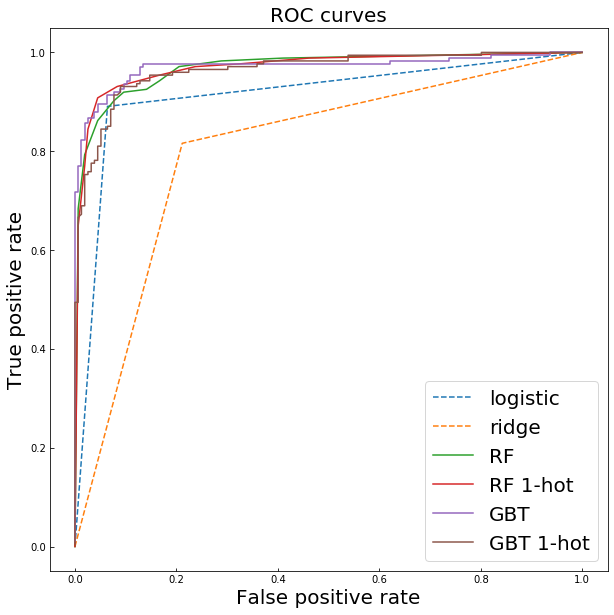

In [302]:
pl.figure(figsize=(10,10))
pl.plot(fpr_grd_logit, tpr_grd_logit, '--', label='logistic')
pl.plot(fpr_grd_ridge, tpr_grd_ridge, '--', label='ridge')
pl.plot(fpr_grd_rf, tpr_grd_rf, label='RF')
pl.plot(fpr_grd_rfcat, tpr_grd_rfcat, label='RF 1-hot')
pl.plot(fpr_grd_gb, tpr_grd_gb, label='GBT')
pl.plot(fpr_grd_gbcat, tpr_grd_gbcatt, label='GBT 1-hot')
pl.legend(fontsize=20)
pl.xlabel('False positive rate', fontsize=20)
pl.ylabel('True positive rate', fontsize=20)
pl.title('ROC curves', fontsize=20);

# the best part is feature importance

In [304]:
#the feature importance is a measure of how soon and how often a feature was used and is encded as a 0-1 number per feature
rfnum.feature_importances_

array([ 0.22777358,  0.48080806,  0.06439826,  0.08731261,  0.13970749])

In [305]:
importancesrf = rfnum.feature_importances_
importancesrf
std = np.std([onetree.feature_importances_ for onetree in rf.estimators_],
             axis=0)
indicesrf = np.argsort(importancesrf)[::-1]




# Print the feature ranking
print("Feature ranking:")

for f in range(Xnum.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indicesrf[f], 
                                   nychouses.drop(["price","sale_type"], axis=1).columns[
                indicesrf[f]],
                                   importancesrf[indicesrf[f]]))


Feature ranking:
1. feature 1 sqft (0.480808)
2. feature 0 zip (0.227774)
3. feature 4 sale_type_num (0.139707)
4. feature 3 bathrooms (0.087313)
5. feature 2 bedrooms (0.064398)


In [306]:
importancesrfcat = rfcat.feature_importances_
indicesrfcat = np.argsort(importancesrfcat)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X1hot.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indicesrfcat[f], 
                                   nyc1hot.drop("price", axis=1).columns[
                indicesrfcat[f]],
                                   importancesrfcat[indicesrfcat[f]]))


Feature ranking:
1. feature 0 sqft (0.289139)
2. feature 2 bathrooms (0.151134)
3. feature 64 Co-op For Sale (0.088855)
4. feature 1 bedrooms (0.059722)
5. feature 65 Condo For Sale (0.035429)
6. feature 46 11096 (0.028638)
7. feature 16 10019 (0.017218)
8. feature 42 11001 (0.016900)
9. feature 5 10004 (0.016087)
10. feature 33 10037 (0.013624)
11. feature 70 New Construction (0.013001)
12. feature 17 10021 (0.012830)
13. feature 69 House For Sale (0.012335)
14. feature 31 10035 (0.011249)
15. feature 32 10036 (0.010027)
16. feature 44 11005 (0.009683)
17. feature 13 10016 (0.009632)
18. feature 11 10013 (0.009542)
19. feature 71 Townhouse For Sale (0.008946)
20. feature 9 10011 (0.008690)
21. feature 28 10032 (0.008437)
22. feature 45 11040 (0.008029)
23. feature 20 10024 (0.008010)
24. feature 34 10038 (0.007813)
25. feature 51 11105 (0.006616)
26. feature 66 For Sale by Owner (0.006616)
27. feature 8 10010 (0.006453)
28. feature 62 Apartment For Sale (0.006433)
29. feature 39 10069

In [307]:
gbnum.feature_importances_

array([ 0.36600076,  0.3906799 ,  0.07013448,  0.08995381,  0.08323105])

In [308]:
importancesgbc = gbnum.feature_importances_
indicesgbc = np.argsort(importancesgbc)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xnum.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indicesgbc[f], 
                                   nychouses.drop(["price","sale_type"], axis=1).columns[
                indicesgbc[f]],
                                   importancesgbc[indicesgbc[f]]))


Feature ranking:
1. feature 1 sqft (0.390680)
2. feature 0 zip (0.366001)
3. feature 3 bathrooms (0.089954)
4. feature 4 sale_type_num (0.083231)
5. feature 2 bedrooms (0.070134)


In [309]:
importancesgbcat = gbcat.feature_importances_
indicesgbcat = np.argsort(importancesgbcat)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X1hot.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indicesgbcat[f], 
                                   nyc1hot.drop(["price"], axis=1).columns[
                indicesgbcat[f]],
                                   importancesgbcat[indicesgbcat[f]]))


Feature ranking:
1. feature 0 sqft (0.240497)
2. feature 2 bathrooms (0.080845)
3. feature 64 Co-op For Sale (0.049673)
4. feature 65 Condo For Sale (0.041967)
5. feature 46 11096 (0.041487)
6. feature 1 bedrooms (0.038056)
7. feature 42 11001 (0.036124)
8. feature 45 11040 (0.025831)
9. feature 33 10037 (0.025345)
10. feature 55 11229 (0.025099)
11. feature 6 10006 (0.022733)
12. feature 9 10011 (0.021756)
13. feature 16 10019 (0.020317)
14. feature 15 10018 (0.020053)
15. feature 69 House For Sale (0.019881)
16. feature 22 10026 (0.019255)
17. feature 29 10033 (0.018488)
18. feature 31 10035 (0.017219)
19. feature 36 10040 (0.017088)
20. feature 44 11005 (0.016552)
21. feature 53 11109 (0.016310)
22. feature 61 11436 (0.015560)
23. feature 32 10036 (0.014830)
24. feature 43 11004 (0.013882)
25. feature 11 10013 (0.013641)
26. feature 70 New Construction (0.012832)
27. feature 34 10038 (0.011354)
28. feature 13 10016 (0.010389)
29. feature 30 10034 (0.010328)
30. feature 39 10069 (0.0

In [310]:
print ("different sorting by feature importance for RF and GBT")
indicesrf - indicesgbc, indicesrfcat - indicesgbcat

different sorting by feature importance for RF and GBT


(array([ 0,  0,  1, -1,  0]),
 array([  0,   0,   0, -64,  19,  45, -26,  -3, -28, -22,  64,   8,  53,
         16, -37,  22, -16, -20,  35, -35, -25, -16, -12,  -9,  40,  -4,
        -26,  49,   9,  10,  23,  36, -20,   9,   9, -40,  32,  23, -21,
         33,  11, -30, -15, -59, -16,  -9,  37, -62, -53,  10,  17,  14,
         61,  17,  -4, -45, -20,  10, -49,  27,   2, -27, -33,   6,  16,
        -25,  40,   0,  34, -17,  33,  18]))

# Feature importance - numerical encoding

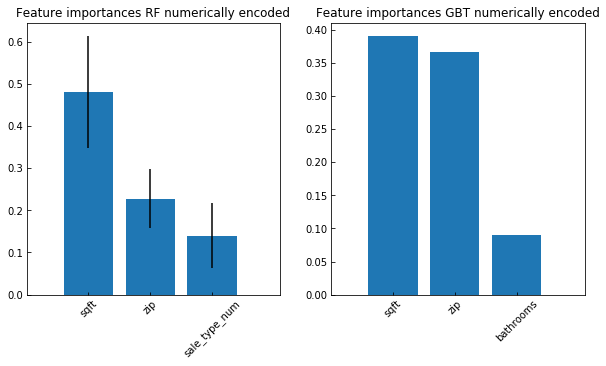

In [311]:
import pylab as pl
fig = pl.figure(figsize=(10,5))

ax = fig.add_subplot(121)
importances = rfnum.feature_importances_
importances
std = np.std([onetree.feature_importances_ for onetree in rfnum.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]



# Plot the feature importances of the forest
Nf = 3
pl.title("Feature importances RF numerically encoded")
pl.bar(range(Nf), importances[indices[:Nf]],
       yerr=std[indices[:Nf]], align="center")
pl.xticks(range(Nf), nychouses.drop(["price","sale_type"], axis=1).columns[indices[:Nf]])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
pl.xlim([-1, Nf + 0.1])

importances = gbnum.feature_importances_
importances
indices = np.argsort(importances)[::-1]


ax = fig.add_subplot(122)

# Plot the feature importances of the forest

pl.title("Feature importances GBT numerically encoded")
pl.bar(range(Nf), importances[indices[:Nf]], align="center")
pl.xticks(range(Nf), nychouses.drop(["price","sale_type"], axis=1).columns[indices[:Nf]])
pl.xlim([-1, Nf + 0.1])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
pl.show()


# Feature importance: one-hot encoding

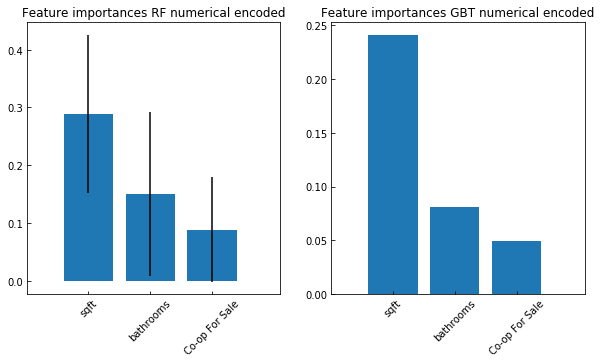

In [312]:
fig = pl.figure(figsize=(10,5))

ax = fig.add_subplot(121)
importances = rfcat.feature_importances_
importances
std = np.std([onetree.feature_importances_ for onetree in rfcat.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]



# Plot the feature importances of the forest

pl.title("Feature importances RF numerical encoded")
pl.bar(range(Nf), importances[indices[:Nf]],
       yerr=std[indices[:Nf]], align="center")
pl.xticks(range(Nf), nyc1hot.drop(["price"], axis=1).columns[indices[:Nf]])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
pl.xlim([-1, Nf + 0.1])

importances = gbcat.feature_importances_
importances
indices = np.argsort(importances)[::-1]


ax = fig.add_subplot(122)

# Plot the feature importances of the forest
Nf = 3
pl.title("Feature importances GBT numerical encoded")
pl.bar(range(Nf), importances[indices[:Nf]], align="center")
pl.xticks(range(Nf), nyc1hot.drop(["price"], axis=1).columns[indices[:Nf]])
pl.xlim([-1, Nf + 0.1])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

pl.show()

# The moral of the story is: beware of hot encoding and feature importance!